In [1]:
using JLD2
using Printf
using CairoMakie
using FourierFlows
using LsqFit
include("AnalysisUtils.jl")

compute_Ω (generic function with 2 methods)

In [2]:
function read_frequency_sign(directory)
    file = jldopen(@sprintf("%s/packets.%06d.jld2", directory, 0))
    freq_sign = file["params/ωsign"]
    close(file)
    return freq_sign
end

read_frequency_sign (generic function with 1 method)

In [3]:
data_directory = "/scratch/nad9961/swqg_rays/57013806/"

grid = TwoDGrid(Lx = 2π, nx = 512)
t, q, ψ, u, v, Kd2 = load_qgsw_snapshot(data_directory, grid, 6)
f_, Cg = read_parameters(data_directory)
freq_sign = read_frequency_sign(data_directory)
max_snap_idx = count_snapshots(data_directory)
skip_every = 20
Nsnaps = ceil(Int, max_snap_idx / skip_every)#count_snapshots(data_directory)
Npackets = 25
ts = zeros(Nsnaps)
ks = zeros(Nsnaps, Npackets, 2)
ωs = zeros(Nsnaps, Npackets)
dops = zeros(Nsnaps, Npackets)
Ωs = zeros(Nsnaps, Npackets)
cutoff_freq_sign = freq_sign[1:Npackets]
for true_idx=1:skip_every:max_snap_idx
    i = Int((true_idx-1)/skip_every) + 1
    (t, x, k, U) = load_snapshot(data_directory, true_idx+1)
    k = k[1:Npackets, :]
    U = U[1:Npackets, :]
    ts[i] = t
    ks[i, :, :] = k
    ωs[i, :] = compute_ω(k, f_, Cg, cutoff_freq_sign)
    dops[i, :] = compute_doppler_shift(k, U)
    Ωs[i, :] = compute_Ω(k, U, f_, Cg, cutoff_freq_sign)
end

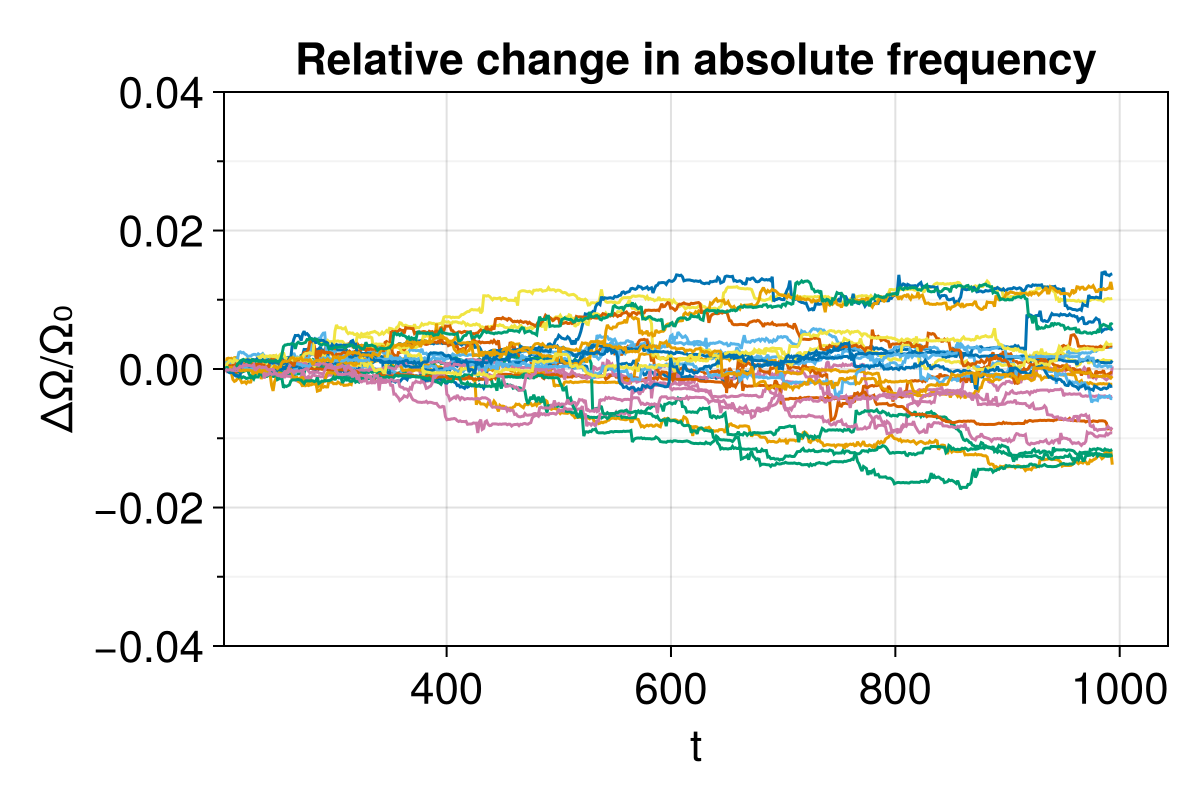

In [30]:
fig = Figure(size=(600, 400), fontsize=22)
ax = Axis(fig[1,1]; title="Relative change in absolute frequency",
    xlabel="t", ylabel="ΔΩ/Ω₀",
    limits=((ts[1], ts[end]*1.05), (-0.04, 0.04)),
    yticks=-0.04:0.02:0.04,
    yminorticksvisible = true, yminorgridvisible = true, yminorticks=IntervalsBetween(2))
for i=1:25
    lines!(ax, ts[2:(Nsnaps)], (Ωs[2:(Nsnaps),i] .- Ωs[2, i]) / Ωs[2,i])
end
save("../images/stationary_background/absolute_freq.png", fig)
fig

In [296]:
ts = zeros(Nsnaps)
pos_ω_mean = zeros(Nsnaps)
pos_dop_mean = zeros(Nsnaps)
neg_ω_mean = zeros(Nsnaps)
neg_dop_mean = zeros(Nsnaps)

max_dop = 15
Nbins = 200
bin_center = 2 * max_dop * (0:(Nbins-1))/Nbins .+ max_dop * (1 - 2*Nbins) / (2 * Nbins)
pos_doppler_distribution = zeros(Nsnaps, Nbins)
neg_doppler_distribution = zeros(Nsnaps, Nbins)

pos_filter = (freq_sign .== 1)
neg_filter = (freq_sign .== -1)
for true_idx=1:skip_every:max_snap_idx
    i = Int((true_idx-1)/skip_every) + 1
    (t, x, k, U) = load_snapshot(data_directory, true_idx)
    ts[i] = t
    ω = compute_ω(k, f_, Cg, freq_sign)
    dop = compute_doppler_shift(k, U)
    
    bin_idx = floor.(Int, (dop .+ max_dop) / (2*max_dop) * Nbins) .+ 1
    bin_idx = @. min(max(bin_idx, 1), Nbins)
    for j=1:Nbins
        pos_doppler_distribution[i, j] = sum(bin_idx[pos_filter] .== j) / length(bin_idx[pos_filter])
        neg_doppler_distribution[i, j] = sum(bin_idx[neg_filter] .== j) / length(bin_idx[neg_filter])
    end
    pos_ω_mean[i] = mean(ω[pos_filter])
    pos_dop_mean[i] = mean(dop[pos_filter])
    neg_ω_mean[i] = mean
    (ω[neg_filter])
    neg_dop_mean[i] = mean(dop[neg_filter])
end

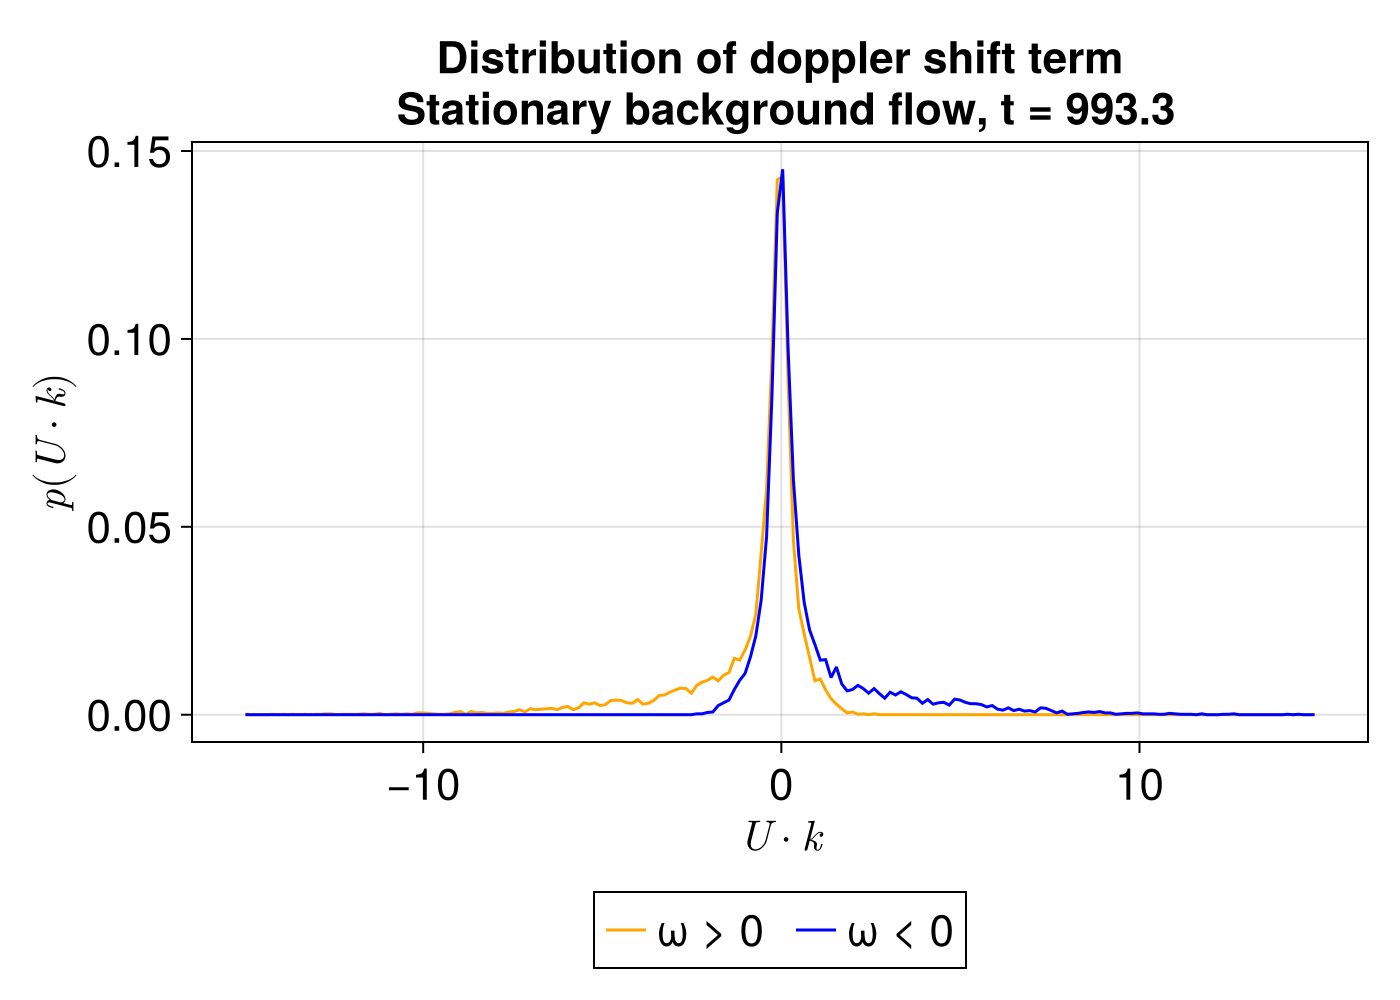

In [346]:
fig0 = Figure(size=(700, 500), fontsize=22)
ax = Axis(fig0[1,1];
        title = @sprintf("Distribution of doppler shift term\n Stationary background flow, t = %0.1f", ts[end]),
        xlabel=L"U⋅k", ylabel=L"p(U⋅k)")
lines!(ax, bin_center, pos_doppler_distribution[end, :], color=:orange, label="ω > 0")
lines!(ax, bin_center, neg_doppler_distribution[end, :], color=:blue, label="ω < 0")
fig0[2,1] = Legend(fig0, ax, orientation=:horizontal)
save("../images/stationary_background/doppler_distribution.png", fig0)
fig0

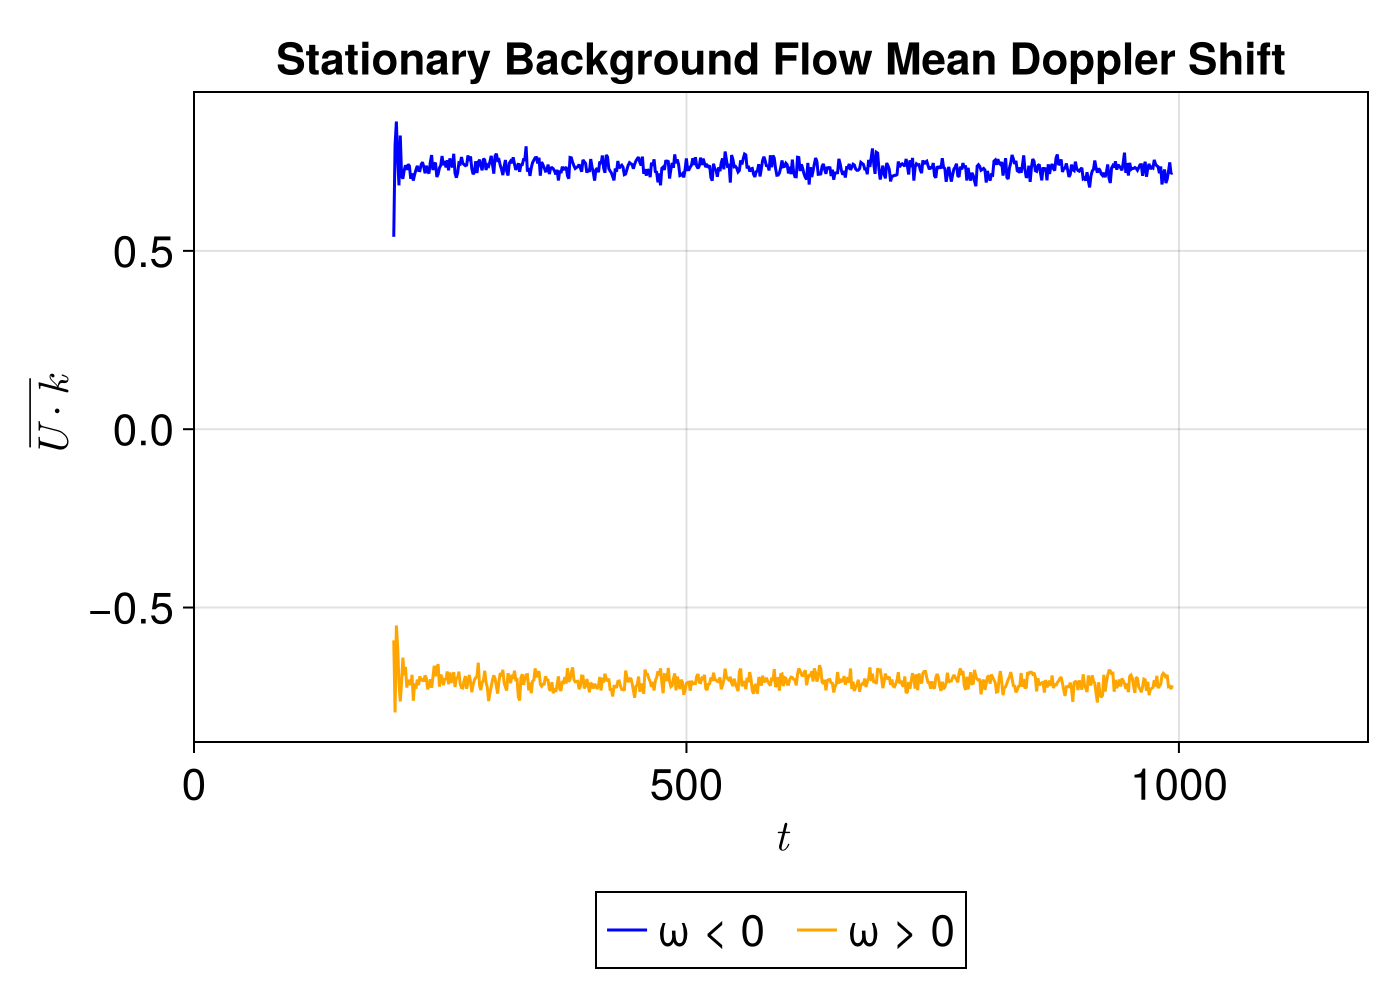

In [347]:
fig2 = Figure(size=(700, 500), fontsize=22)
ax = Axis(fig2[1,1]; title="Stationary Background Flow Mean Doppler Shift",
            limits=((0, ts[end]*1.2), (nothing, nothing)),
            xlabel=L"t", ylabel=L"\overline{U⋅k}")

#lines!(ax, ts[2:end], ω_mean[2:end],   label="ω(k)")
lines!(ax, ts[2:end], neg_dop_mean[2:end], label="ω < 0", color=:blue)
lines!(ax, ts[2:end], pos_dop_mean[2:end], label="ω > 0", color=:orange)
fig2[2,1] = Legend(fig2, ax, orientation=:horizontal)
save("../images/stationary_background/mean_doppler_shift.png", fig2)
fig2